In [1]:
import sys
sys.path.append("..")

In [22]:
from rascal.calibrator import Calibrator
import numpy as np
from scipy.signal import find_peaks
from astropy.io import fits
from tqdm.autonotebook import tqdm
from rascal import models

In [23]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Users\Josh\AppData\Local\conda\conda\envs\astro\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['f']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


This notebook highlights how certain aspects of RASCAL work. Let's load some manually identified peaks:

In [84]:
peaks, wavelengths, lamps = np.loadtxt("./ground_truth_v_a.csv", delimiter=',', dtype='U').T

peaks = peaks.astype('float32')
wavelengths = wavelengths.astype('float32')
lamps = np.unique(lamps)

In [85]:
print(peaks,wavelengths)

[241. 247. 260. 269. 280. 285. 294. 310. 335. 359. 462. 468. 477. 508.
 530. 545. 553. 575. 592. 605. 635. 694. 709. 721. 730. 741. 752. 763.
 773. 803. 832. 836. 860. 877. 899. 932. 945. 963. 980.] [4500.98 4524.68 4582.75 4624.28 4671.23 4697.02 4734.15 4807.02 4921.48
 5028.28 5496.07 5531.07 5566.62 5716.2  5823.89 5893.29 5931.24 6036.2
 6114.86 6178.3  6318.06 6595.56 6668.92 6728.01 6771.57 6827.32 6872.11
 6925.53 6976.18 7119.6  7257.9  7284.3  7393.8  7474.   7584.68 7740.31
 7802.65 7887.4  7967.34]


Now we instantiate a calibrator. In this case, we know that our wavelength range is around 3400 to 8000 Angstrom.

In [26]:
c = Calibrator(peaks, elements=lamps, min_wavelength=3400., max_wavelength=8100.)
c.set_fit_constraints(n_pix=1024,
                      range_tolerance=200)


# Get the true linear fit
m_true, c_true = c._robust_polyfit(peaks, wavelengths, 1)

RASCAL begins by enumerating all possible peak/emission line pairs. Here we've overlaid the true fit with a black line.

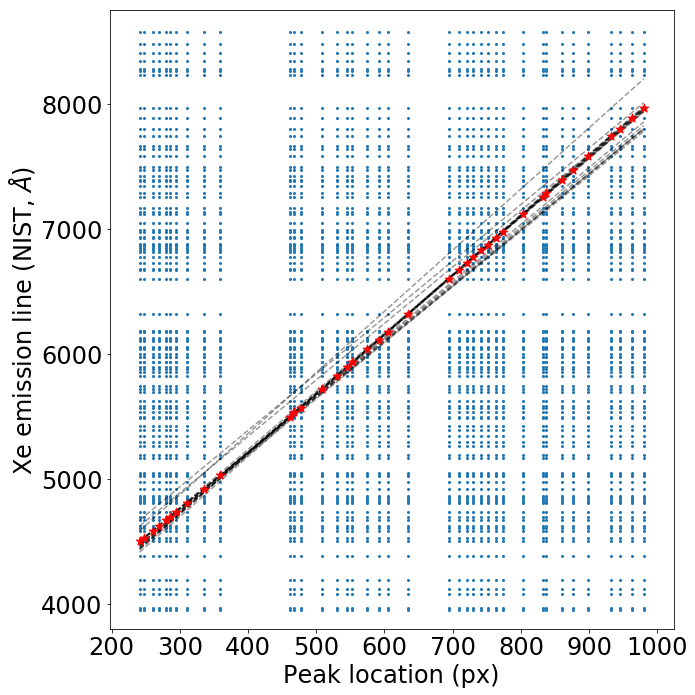

In [55]:
fig = figure(figsize=(10,10))
fig.set_rasterized(True)

ax = fig.add_subplot(111)

ax.set_rasterized(True)

ax.scatter(*c.pairs.T, s=4)
x = np.linspace(min(peaks), max(peaks))
    
plt.xlabel("Peak location (px)", fontsize=24)
plt.ylabel("Xe emission line (NIST, $\AA$)", fontsize=24)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

ax.scatter(peaks, wavelengths, c='red',s=80, marker='*',label="True match", zorder=20)

f = models.linear((m_true, c_true))
#plot(x, f(x) ,c='black', label="True linear fit")
#legend()
plt.ylim(3800,8750)



for l in lines:
    #title("{} {}".format(*l))
    candidate_peaks, candidate_wavelengths = c._get_candidate_points(l[0], l[1], thresh=15)
    f = models.linear(l)
    plot(x, f(x), alpha=0.4, c='black', linestyle='dashed')
    
    if plot_legend:
        #scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, label="Candidate match", alpha=1)
        plot_legend = False
    #else:
        #scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, alpha=0.3)

plt.tight_layout()
plt.savefig("./P10-37_F1.eps", rasterized=True)

Next we run the Hough Transform

In [28]:
accumulator = c._hough_points(c.pairs[:,0], c.pairs[:,1], num_slopes=500)

And let's plot the accumulator

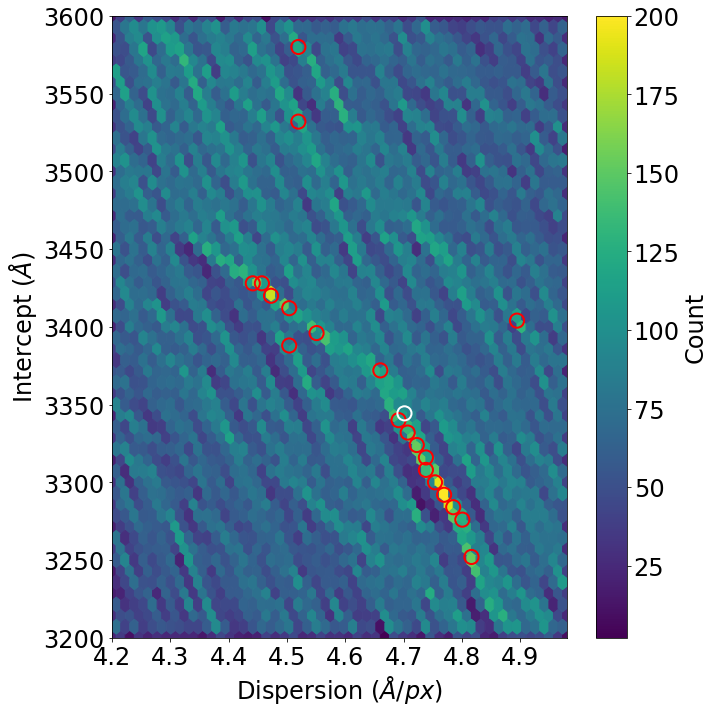

In [52]:
fig = figure(figsize=(10,10))
plt.hexbin(*accumulator.T, gridsize=50)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel("Dispersion ($\AA / px$)", fontsize=24)
plt.ylabel("Intercept ($\AA$)", fontsize=24)
cb = colorbar()
cb.set_label("Count", fontsize=24)
cb.ax.tick_params(labelsize=24) 
_, lines = c._get_top_lines(accumulator, top_n=20, xbins=50, ybins=50)

for l in lines:
    scatter(l[0], l[1], s=200, edgecolors='red', facecolors='None', linewidths=2)

scatter(m_true, c_true, s=200, edgecolors='white', facecolors='None', linewidths=2)
plt.tight_layout()
plt.savefig("./P10-37_F2.eps")

The white circle is the true linear fit, whilst the red circles are the top 20 peaks in the histogram.

We can look at those lines and which peak/emission line pairs they correspond to. We set the threshold to be quite low, 15A to only get points which are in strong agreement.

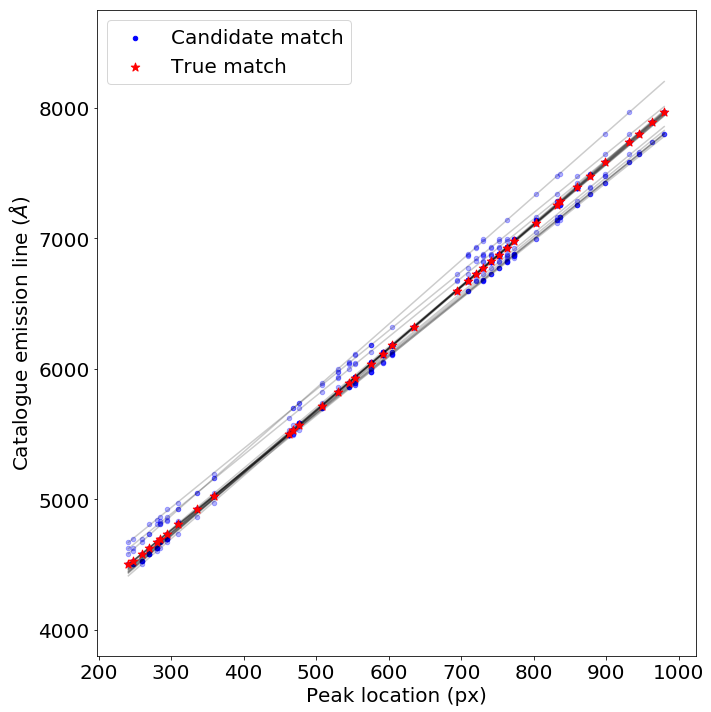

In [33]:
fig = figure(figsize=(10,10))

plot_legend = True
for l in lines:
    #title("{} {}".format(*l))
    candidate_peaks, candidate_wavelengths = c._get_candidate_points(l[0], l[1], thresh=15)
    f = models.linear(l)
    plot(x, f(x), alpha=0.2, c='black')
    
    if plot_legend:
        scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, label="Candidate match", alpha=1)
        plot_legend = False
    else:
        scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, alpha=0.3)
    
scatter(peaks, wavelengths, c='red',s=80, marker='*',label="True match", zorder=20)
    
plt.xlabel("Peak location (px)", fontsize=20)
plt.ylabel("Catalogue emission line ($\AA$)", fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.ylim(3800,8750)
plt.tight_layout()
plt.savefig("candidate_fits.eps", rasterized=True)

The red circles here are the true matches. You see that there's a heavy black line running through them. That particular line is not straight, it's actually two clusters of straight lines which are tracing out a parabola. What's going on here?

There are a family of lines which match the peaks at 200-400px and a group which matches the peaks at 700-1000px. It's easier to see on separate curves:

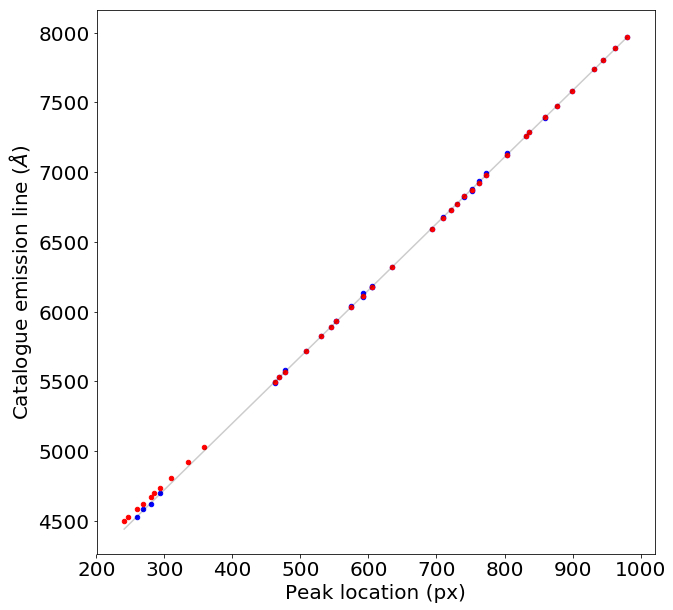

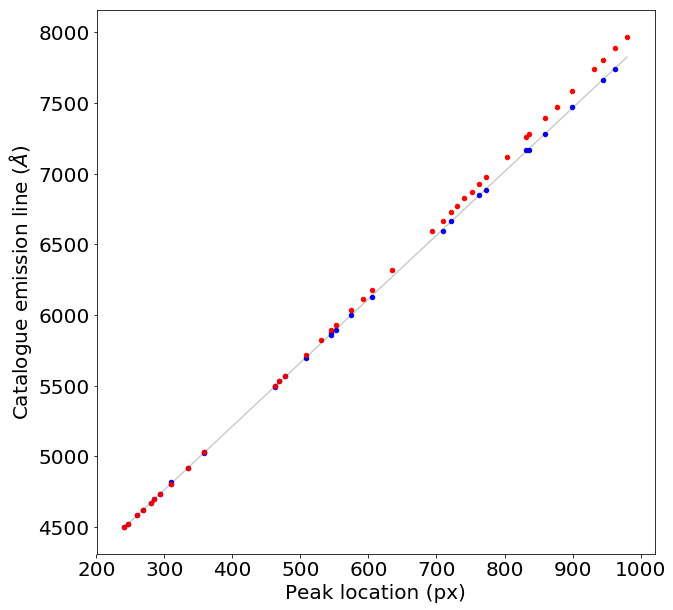

In [11]:
for l in (lines[0], lines[13]):
    figure(figsize=(10,10))
    #title("{} {}".format(*l))
    candidate_peaks, candidate_wavelengths = c._get_candidate_points(l[0], l[1], thresh=15)
    f = models.linear(l)
    plot(x, f(x), alpha=0.2, c='black', label="Linear fit")
    
    scatter(candidate_peaks, candidate_wavelengths, c='blue', s=20, label="Candidate match")
    scatter(peaks, wavelengths, c='red',s=20, label="Actual match")

    
    plt.xlabel("Peak location (px)", fontsize=20)
    plt.ylabel("Catalogue emission line ($\AA$)", fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    #plt.legend()

RASCAL tries to take advantage of this by combining the information from all the top lines. For each linear fit, we go through all the peaks and add the closest matching wavelength. We combine all these points into one big list and we pick the peak/wavelength pairs that are the most common. What we end up is something like this:

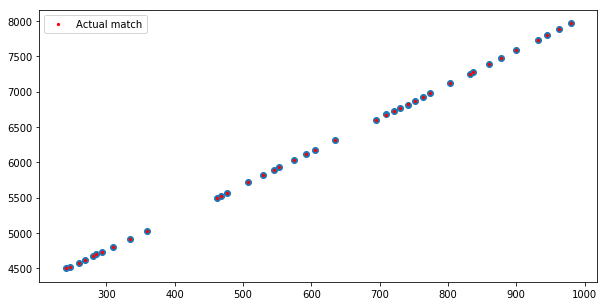

In [12]:
plt.figure(figsize=(10,5))
candidates = [c._get_candidate_points(l[0], l[1], thresh=15) for l in lines]
out_p, out_w = c._combine_linear_estimates(candidates)
scatter(out_p, out_w)
scatter(peaks, wavelengths, c='red',s=5, label="Actual match")
legend()

By combining the information from separate lines, we've managed to extract all the correct points pretty much perfectly. In real life we would probably have noisier peak extraction, but this shows the sorts of results you can get. Now we just run RANSAC.

In [13]:
_, lines = c._get_top_lines(accumulator, top_n=10, xbins=20, ybins=20)
candidates = [((l[0], l[1]), c._get_candidate_points(l[0], l[1], thresh=20)) for l in lines]

In [14]:
res = c._solve_candidate_ransac(x=out_p, y=out_w, thresh=7, max_tries=1e4, coeff=None, progress=True)

And we can compare our fit values to the actual ones; the residuals are very small.

In [15]:
x = peaks
y = np.polyval(np.array([-2.96095506e-07,  7.80217238e-04,  4.11542174e+00,  3.46571418e+03]), peaks)

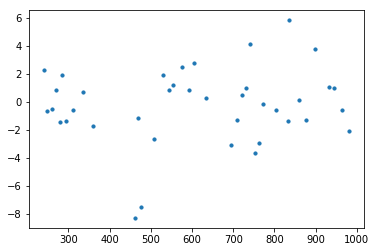

In [16]:
scatter(peaks, wavelengths-y, s=10)

(1024,)


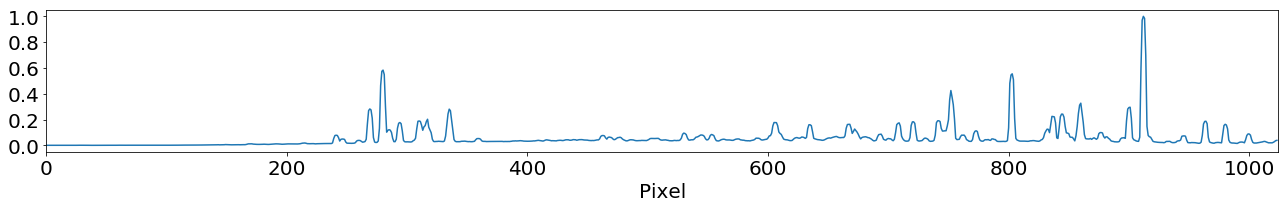

In [17]:
spectrum = np.median(fits.open('v_a_20190516_55_1_0_1.fits')[0].data[110:120], axis=0)
print(spectrum.shape)
peaks, _ = find_peaks(spectrum, height=800, distance=5, threshold=None)

plt.figure(figsize=(18,3))
plt.plot(spectrum/spectrum.max())
plt.xlabel("Pixel", fontsize=20)
plt.xlim(0,1024)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.tight_layout()
plt.savefig("P10-37_F0.eps")

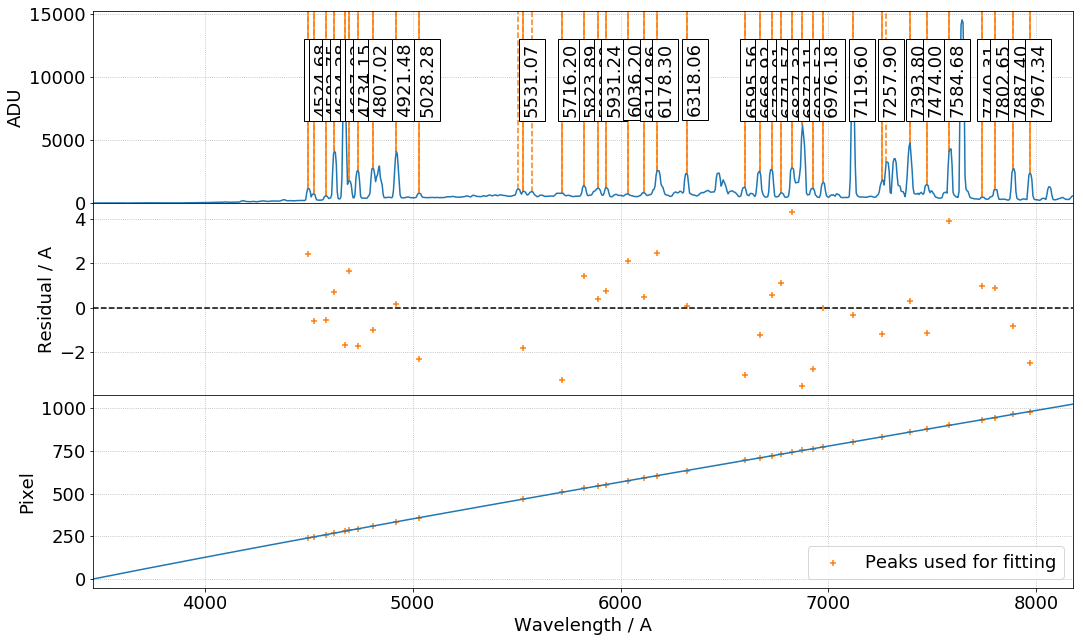

In [53]:
matplotlib.rcParams['font.size'] = 18
c.plot_fit(spectrum, res[0], output_filename="P10-37_F4.eps")

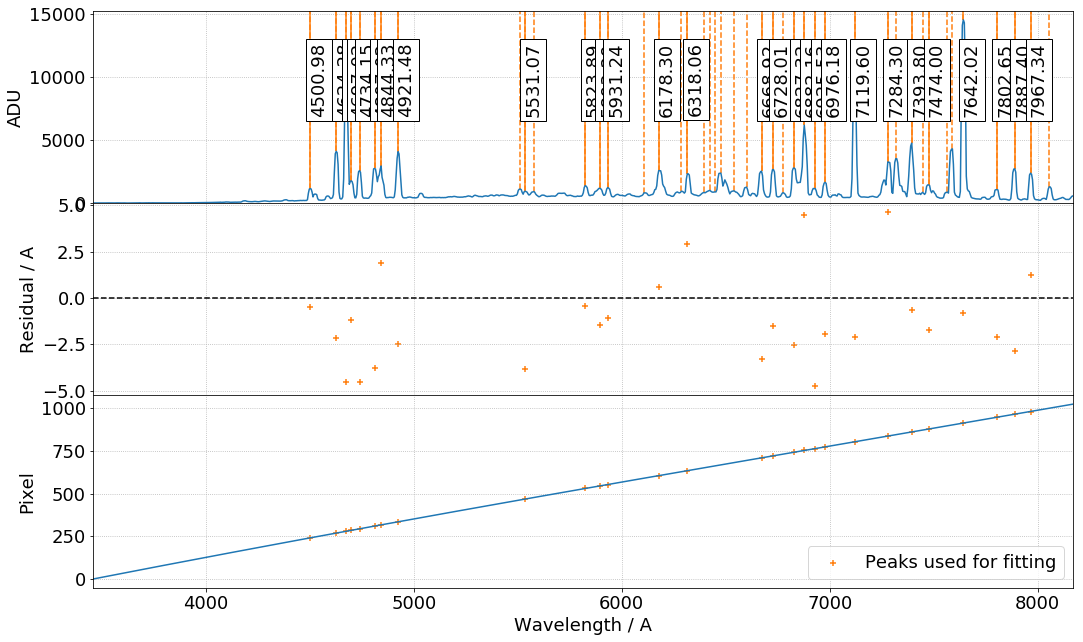

In [93]:
# Test with actual data

spectrum = np.median(fits.open('v_a_20190516_55_1_0_1.fits')[0].data[110:120], axis=0)
peaks, _ = find_peaks(spectrum, height=800, distance=5, threshold=None)

c = Calibrator(peaks, elements=lamps, min_wavelength=3400., max_wavelength=8100.)
c.set_fit_constraints(n_pix=1024)

p = c.fit(max_tries=3e4)
c.plot_fit(spectrum, p)